# 폐렴 진단하기 & 성능 개선
폐렴인지 아닌지에 대한 진단을 내릴 수 있는 딥러닝 모델 만들기.  
  
성능 개선을 위해 세 가지를 조절하며 성능 개선을 하겠다.   
(1) **Data augmentation**   
(2) **Batch size, Epoch**  
(3) **BatchNormalization / Dropout** 
  
**Accuracy 85%** 이상의 모델을 생성하는 것이 이번 프로젝트의 목표이다.  
  
---
    
#### 폐렴이란?  
폐렴(pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다. 세균을 통한 감염이 가장 많으며, 바이러스, 균류, 또는 기타 미생물도 원인이 될 수가 있다. 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 한다. 노인이나 어린아이, 혹은 전체적으로 상태가 안 좋은 환자들이나 기침 반사가 약한 사람들에게는 흡인성 폐렴이 발생한다. 그리고 세균이 원인인 경우는 항생제로 치료를 할 수 있다. 항생제가 생기기 전에는 50~90%가 사망할 정도로 위험한 질환이었으나, 현재는 거의 사망하지 않는다. 1940년대에 항생제가 개발되기 전까지는 폐렴 환자의 1/3 정도가 사망하였다. 오늘날에는 적절한 의학적 치료로 폐렴 환자의 95% 이상이 회복된다. 그러나 일부 저개발국(개발 도상국)에서는 폐렴이 여전히 주요 사망 원인 중 하나이다.  
  
#### 염증  
염증은 유해한 자극에 대한 생체반응 중 하나로 면역세포, 혈관, 염증 매개체들이 관여하는 보호반응이다. 염증의 목적은 세포의 손상을 초기 단계에서 억제하고, 상처 부분의 파괴된 조직 및 괴사된 세포를 제거하며, 동시에 조직을 재생하는 것이다.  
  
#### 폐렴 구별법
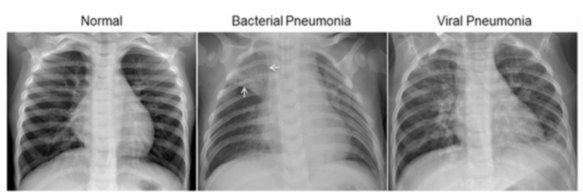
정상적인 흉부 X-RAY(Normal)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여준다.  
세균성 폐렴 (Bacterial Pneumonia)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타낸다.  
바이러스성 폐렴 (Viral Pneumonia)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타난다.  

## 1. SET-UP

In [82]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [106]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [84]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames)) #train 안 데이터 개수
print(len(test_filenames)) #test 안 데이터 개수
print(len(val_filenames)) #val 안 데이터 개수

5216
624
16


In [85]:
# val의 개수가 너무 부족해 train에서 데이터를 가져오자(개수 비 89 : 11 : 0.3)
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 train:val=80:20로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames)) #train 안 데이터 개수
print(len(val_filenames)) #val 안 데이터 개수

4185
1047


In [86]:
#train 데이터 안 정상 이미지와 폐렴 이미지 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [87]:
#정상 이미지 개수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

#폐렴 이미지 개수
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [88]:
#tf.data 인스턴스 생성
#tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [89]:
#Train 데이터셋 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

#Validation 데이터셋 개수
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [90]:
#라벨 데이터 생성
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [91]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [92]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) #train 데이터 셋 생성
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) #validation 데이터 셋 생성

In [93]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape) #이미지 리사이즈 확인
    print("Label: ", label.numpy()) #라벨 생성 확인

Image shape:  (180, 180, 3)
Label:  False


In [94]:
#test 데이터 셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT) #데이터 개수 확인

624


In [95]:
#tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용
#def prepare_for_training(ds, shuffle_buffer_size=1000):  # prepare_for_training() 함수를 정의해 데이터 변환
    #ds = ds.shuffle(buffer_size=shuffle_buffer_size)  #shuffle() : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    #ds = ds.repeat()  #repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다.
    #ds = ds.batch(BATCH_SIZE)  #batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다.
    #ds = ds.prefetch(buffer_size=AUTOTUNE)  #prefetch()는 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.
    #return ds

#train_ds = prepare_for_training(train_ds)
#val_ds = prepare_for_training(val_ds)

In [96]:
#data augmentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

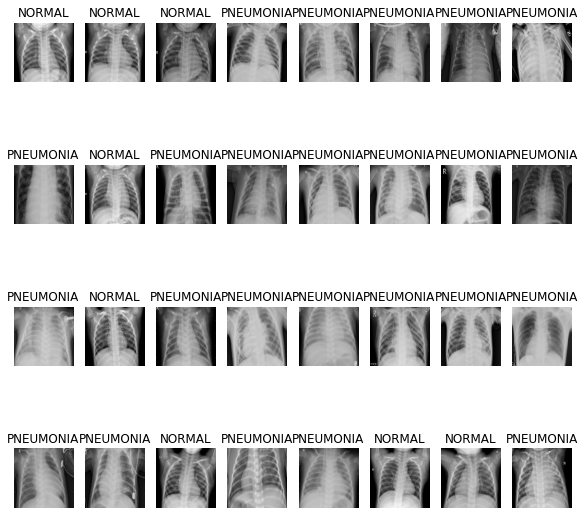

In [97]:
#이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
#train에 있는 batch 중 첫 번째 배치를 추출합니다.
#추출된 배치를 image와 label 데이터 셋으로 나눕니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())  #show_batch() 함수를 이용해서 결과 사진 확인

## 4. CNN 모델링
이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어보자.  
Dropout을 사용하지 않고 BatchNormalization만 사용해 모델링을 진행한다.

In [98]:
#Convolution block 생성
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [99]:
#Dense Block 생성
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [100]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        conv_block(128),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(512),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 더 많다.  
한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.  
training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법인 'Weight balancing'이라는 테크닉을 사용하여 문제를 해결할 수 있다.  

In [101]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0   #'Normal' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  #'Pneumonia' 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}  # weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [107]:
with tf.device('/GPU:0'):  #GPU를 사용한 이미지 훈련
    model = build_model()  #모델 선언

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [108]:
#모델 fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 57s 373ms/step - loss: 0.4955 - accuracy: 0.7447 - precision: 0.9283 - recall: 0.7115 - val_loss: 0.5792 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 372ms/step - loss: 0.2207 - accuracy: 0.9214 - precision: 0.9783 - recall: 0.9149 - val_loss: 0.7094 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 49s 374ms/step - loss: 0.1891 - accuracy: 0.9334 - precision: 0.9770 - recall: 0.9325 - val_loss: 1.0466 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 50s 382ms/step - loss: 0.1463 - accuracy: 0.9466 - precision: 0.9816 - recall: 0.9461 - val_loss: 1.3982 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 50s 388ms/step - loss: 0.1445 - accura

## 7. 결과 확인

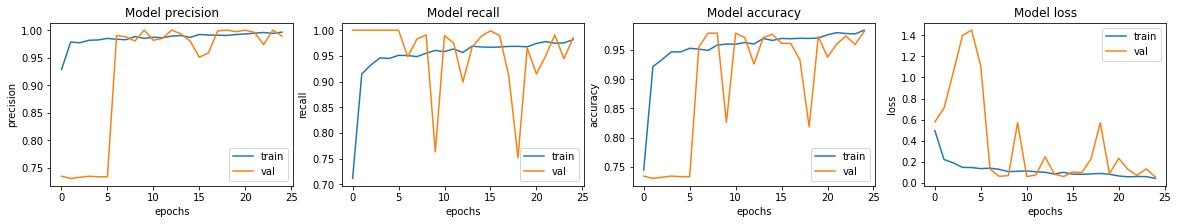

In [109]:
#Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여지는 그래프
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [110]:
#테스트 데이터로 모델 평가
#loss, accuracy, precision, recall 값 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 210ms/step - loss: 1.3070 - accuracy: 0.7324 - precision: 0.7016 - recall: 0.9949
Loss: 1.3069924116134644,
Accuracy: 0.7323718070983887,
Precision: 0.7016274929046631,
Recall: 0.9948717951774597


Accuracy가 73%로 도출되었다.

---
## EXPLORATION 9 회고
  
(1) **Data augmentation** 기법 적용  
이미지 좌우 반전 augmentation을 사용했고, 시각화해보니 확연히 적용하기 이전보다 시각적으로 폐렴 정도를 구분하기 쉬웠다.(물론, '적용 이전과 비교해서'이며 실제로 의료용 데이터를 처음 접한 내 눈으로 비교하는건 큰 어려움이 있었다.)  
아쉬웠던 점은, 실습에서 augment에 대해 다루며 이에 대한 지식을 더 얻었으면 실습에 대한 이해도가 더 높았을 것 같은데, 프로젝트를 진행하며 스스로 augmentation기법에 대해 공부하니 이해도가 현저히 낮았다.  
아직까지도 augment에 대한 지식이 낮고, 이걸 적용 했을 때 실제로 크게 정확도 향상에 도움이 되는지는 확실하지 않다. 기법 적용 이전과 data augmentation만 적용했을 때는 단 3%의 정확도만 향상 되었기 때문에 ..  
  
(2) **Batch size 및 Epoch 조절**    
batchsize는 16->32 , Epoch는 25->50->30->22->25으로 조절했다.  
batchsize는 큰 영향이 없는 것 같다. epcoh는 높이면 높일수록 더 정교한 모델 학습이 가능해질 것이라 예상했지만 오버피팅이 나타났고 22에서는 갑자기 그래프가 뚝 떨어져 무려 2%의 accuracy가 나타났다 ..ㅋㅋㅋ 처음에 시도했던 25가 그나마 가장 괜찮은 모델을 만들어 냈다. 이전 실습에서는 epoch가 2일때 가장 정확도가 높았고, 점점 커질수록 정확도가 낮아졌었는데 이렇게 다른 데이터를 가진 모델학습마다 다른 결과가 나오는걸 보는게 흥미롭다.  
  
(3) **BatchNormalization / Dropout / 둘 다 사용**  
Dropout제거, BatchNormalization 제거, 둘 다 사용 세 가지 실험을 했고, 그 중 둘 다 사용했을 때 가장 높은 학습 결과가 나왔다. Dropout을 제거했을 땐 70%, BatchNormalization을 제거했을 땐 67%로 예상보다 낮게 나왔다. 처음 둘 다 사용했던 기존 실습에서 높은 정확도가 나오길래 의아했는데, 역시 둘 다 사용하는 것이 정확도에 큰 영향을 미친다는 것을 알게되었다.   

(4) **build model conv_block() 조절**  
conv block의 수를 제곱만큼 크게 조절해줬다. 32->64, 64->128 이렇게.. 조절했을 때 조절하기 전보다 5% 더 높은 정확도를 얻게되었다.  
이건 처음에는 건들 생각이 없었던 변수였는데, 실습 중에 정확도를 높이고자 수를 조정했더니 그나마 괜찮은 결과를 얻었다 
  
   
처음 아무것도 안건들였을땐 85%의 정확도가 나왔는데, 점점 뭘 건들수록 낮아지더니 결국
70%대로 제출하게 되었다. 뭐가 잘못된걸까..   
다양한 데이터가 많은데, 의료용 데이터를 막연하게 다뤄보고 싶다는 생각이 있었지만, 워낙 로데이터를 얻기 힘들 것이라고 생각했다. 이번 익스에서 뭔가 경험이라도 해보게 되어서 아주 흥미로웠던 프로젝트이다.   
뭔가 이번 실습에서 이상한 점은 하나의 모델을 돌리고, 성능 개선을 위해 다른 모델을 돌리면 자꾸 오류가 나고 튕긴다는 점이다. 결국 모델마다 각각 다른 노트북을 만들어 실험한 후 가장 좋은 값이 나온 노트북을 제출할수밖에 없었다. 오류의 이유를 모르겠고, 자꾸 모델하다가 튕기는것은 내 컴퓨터 사양때문인지 궁금.. 다음에도 이런 의료데이터를 다룰 수 있는 기회가 있었으면 좋겠다!  
  
---
2022-02-10